# Universidad Del Valle de Guatemala
## Deep Learning
### Proyecto Final: Red Neuronal Recurrente que predice el ganador de un partido de la liga BBVA.
#### Integrantes: 
- Roberto Rios 20979
- Javier Mombiela 20067

#### Importación de librerias

In [166]:
import json
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.model_selection import train_test_split

#### Carga de data

In [167]:
data = pd.read_csv('temporadas.csv')

Visualizacion de data

In [168]:
print(data.count())
data

Date        3800
HomeTeam    3800
AwayTeam    3800
FTHG        3800
FTAG        3800
FTR         3800
HTHG        3800
HTAG        3800
HTR         3800
HS          3800
AS          3800
HST         3800
AST         3800
HF          3800
AF          3800
HC          3800
AC          3800
HY          3800
AY          3800
HR          3800
AR          3800
dtype: int64


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,18/08/13,Barcelona,Levante,7,0,H,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,18/08/13,Osasuna,Granada,1,2,A,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,04/06/2023,Betis,Valencia,1,1,D,1,0,H,8,...,3,3,11,11,5,4,3,0,0,1
3796,04/06/2023,Celta,Barcelona,2,1,H,1,0,H,12,...,9,2,13,9,2,4,2,2,0,0
3797,04/06/2023,Elche,Cadiz,1,1,D,0,1,A,12,...,5,3,18,8,7,4,4,3,0,0
3798,04/06/2023,Espanol,Almeria,3,3,D,1,1,D,12,...,8,4,11,12,7,6,2,3,0,0


Comprobar si hay valores nulos o faltantes en el conjunto de datos

In [169]:
print(data.isnull().sum())

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


#### Preprocesamiento de datos

Codificacion de etiquetas para los equipos y variable objeito FTR (Full Time Result)

In [170]:
team_label_encoder = LabelEncoder()
data['HomeTeam'] = team_label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = team_label_encoder.fit_transform(data['AwayTeam'])

result_label_encoder = LabelEncoder()
data['FTR'] = result_label_encoder.fit_transform(data['FTR'])

Ver la codificacion de cada variable

In [171]:
team_mapping = dict(zip(team_label_encoder.classes_, team_label_encoder.transform(team_label_encoder.classes_)))

team_mapping = {k: int(v) for k, v in team_mapping.items()}
with open('modelos/team_mapping.json', 'w') as f:
    json.dump(team_mapping, f)

print(team_mapping)

{'Alaves': 0, 'Almeria': 1, 'Ath Bilbao': 2, 'Ath Madrid': 3, 'Barcelona': 4, 'Betis': 5, 'Cadiz': 6, 'Celta': 7, 'Cordoba': 8, 'Eibar': 9, 'Elche': 10, 'Espanol': 11, 'Getafe': 12, 'Girona': 13, 'Granada': 14, 'Huesca': 15, 'La Coruna': 16, 'Las Palmas': 17, 'Leganes': 18, 'Levante': 19, 'Malaga': 20, 'Mallorca': 21, 'Osasuna': 22, 'Real Madrid': 23, 'Sevilla': 24, 'Sociedad': 25, 'Sp Gijon': 26, 'Valencia': 27, 'Valladolid': 28, 'Vallecano': 29, 'Villarreal': 30}


In [172]:
result_mapping = dict(zip(result_label_encoder.classes_, result_label_encoder.transform(result_label_encoder.classes_)))
print(result_mapping)

{'A': 0, 'D': 1, 'H': 2}


Visualizar las primeras filas para comprobar la codificacion

In [173]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,17/08/13,25,12,2,0,2,1,0,H,16,...,6,2,13,6,6,5,1,1,0,0
1,17/08/13,27,20,1,0,2,0,0,D,9,...,1,2,15,23,9,6,3,5,0,0
2,17/08/13,28,2,1,2,0,1,1,D,8,...,2,3,10,8,5,5,1,0,0,0
3,18/08/13,4,19,7,0,2,6,0,H,22,...,13,1,15,16,9,3,1,3,0,0
4,18/08/13,22,14,1,2,0,0,2,A,14,...,5,4,15,17,7,6,1,4,0,0


#### Agregar estadisticas a la data

Funciones lambda para calcular estadisticas (puntos, head-to-head wins y diferencia de goles)

In [174]:
# puntos sumados
data['PH'] = data.apply(lambda row: 3 if row['FTR'] == 2 else 1 if row['FTR'] == 1 else 0, axis=1)
data['PA'] = data.apply(lambda row: 3 if row['FTR'] == 0 else 1 if row['FTR'] == 1 else 0, axis=1)

# diferencia de goles
data['GDH'] = data['FTHG'] - data['FTAG']
data['GDA'] = data['FTAG'] - data['FTHG']

# victorias head to head
data['HHHW'] = 0
data['HHAW'] = 0

Calculando las estadisticias de los ultimos 10 partidos

In [175]:
for team in data['HomeTeam'].unique():
    mask = (data['HomeTeam'] == team)
    team_data = data[mask]
    for i in range(len(team_data)):
        data.loc[team_data.index[i], 'PH'] = team_data['PH'].iloc[max(0, i-10):i].sum()
        data.loc[team_data.index[i], 'GDH'] = team_data['GDH'].iloc[max(0, i-10):i].sum()

for team in data['AwayTeam'].unique():
    mask = (data['AwayTeam'] == team)
    team_data = data[mask]
    for i in range(len(team_data)):
        data.loc[team_data.index[i], 'PA'] = team_data['PA'].iloc[max(0, i-10):i].sum()
        data.loc[team_data.index[i], 'GDA'] = team_data['GDA'].iloc[max(0, i-10):i].sum()

for i in range(len(data)):
    previous_matches = data[((data['HomeTeam'] == data.loc[i, 'HomeTeam']) & (data['AwayTeam'] == data.loc[i, 'AwayTeam'])) | ((data['HomeTeam'] == data.loc[i, 'AwayTeam']) & (data['AwayTeam'] == data.loc[i, 'HomeTeam']))][:i]
    
    home_wins = len(previous_matches[((previous_matches['HomeTeam'] == data.loc[i, 'HomeTeam']) & (previous_matches['FTR'] == 2)) | ((previous_matches['AwayTeam'] == data.loc[i, 'HomeTeam']) & (previous_matches['FTR'] == 0))])
    away_wins = len(previous_matches[((previous_matches['HomeTeam'] == data.loc[i, 'AwayTeam']) & (previous_matches['FTR'] == 2)) | ((previous_matches['AwayTeam'] == data.loc[i, 'AwayTeam']) & (previous_matches['FTR'] == 0))])
    
    data.loc[i, 'HHHW'] = home_wins
    data.loc[i, 'HHAW'] = away_wins

Colaborar que si se hayan agregado las nuevas columnas al dataset

In [176]:
data.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HY,AY,HR,AR,PH,PA,GDH,GDA,HHHW,HHAW
3795,04/06/2023,5,27,1,1,1,1,0,H,8,...,3,0,0,1,14,6,1,-8,7,6
3796,04/06/2023,7,4,2,1,2,1,0,H,12,...,2,2,0,0,15,19,5,6,6,10
3797,04/06/2023,10,6,1,1,1,0,1,A,12,...,4,3,0,0,12,6,-1,-11,2,1
3798,04/06/2023,11,1,3,3,1,1,1,D,12,...,2,3,0,0,12,5,-3,-12,1,2
3799,04/06/2023,28,12,0,0,1,0,0,D,15,...,1,3,0,0,14,6,-4,-7,4,1


Colaborar que la suma de los puntos sea y diferencia la correcta (verifiamos con los ultimos 15 partidos de un equipo)

In [177]:
team = 4 # Barcelona con codigo 4

matches = data[(data['HomeTeam'] == team) | (data['AwayTeam'] == team)]

# obtener los ultimos 15 partidos
matches.tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HY,AY,HR,AR,PH,PA,GDH,GDA,HHHW,HHAW
3706,16/04/2023,12,4,0,0,1,0,0,D,5,...,2,1,0,0,15,24,3,8,1,12
3717,23/04/2023,4,3,1,0,2,1,0,H,13,...,4,7,0,0,26,20,17,4,11,2
3726,26/04/2023,29,4,2,1,2,1,0,H,9,...,1,4,0,0,13,25,0,10,3,8
3733,29/04/2023,4,5,4,0,2,3,0,H,15,...,0,2,0,1,26,16,15,0,15,2
3741,02/05/2023,4,22,1,0,2,0,0,D,21,...,0,0,0,1,26,11,15,-2,8,1
3758,14/05/2023,11,4,2,4,0,0,3,A,15,...,1,3,0,0,12,22,-2,8,0,13
3765,20/05/2023,4,25,1,2,0,0,1,A,13,...,4,4,0,0,26,15,14,2,14,4
3772,23/05/2023,28,4,3,1,2,2,0,H,8,...,1,0,0,0,11,22,-8,9,2,8
3784,28/05/2023,4,21,3,0,2,2,0,H,28,...,0,0,0,1,25,4,13,-12,6,0
3796,04/06/2023,7,4,2,1,2,1,0,H,12,...,2,2,0,0,15,19,5,6,6,10


Colaborara que los head to head wins sean los correctos

In [178]:
team1 = 4 # Barcelona con codigo 4
team2 = 7 # celta con codigo 7

matches = data[((data['HomeTeam'] == team1) & (data['AwayTeam'] == team2)) | ((data['HomeTeam'] == team2) & (data['AwayTeam'] == team1))]

# obtener los ultimos 15 partidos
matches.tail(1)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HY,AY,HR,AR,PH,PA,GDH,GDA,HHHW,HHAW
3796,04/06/2023,7,4,2,1,2,1,0,H,12,...,2,2,0,0,15,19,5,6,6,10


#### Procesamiento de datos

Seleccionar las columnas que utilizamos como caracteristicas y la columna objetivo, que en este caso es FTR o Full Time Result, la cual tiene 3 opciones 'H' (o 2 significando que HomeTeam gano) 'A' (o 0 significando que AwayTeam gano) y 'D' (o 1 significando que hubo un empate).

In [179]:
features = ['HomeTeam', 'AwayTeam', 'PH', 'PA', 'GDH', 'GDA', 'HHHW', 'HHAW']

X = data[features]
y = data['FTR']

Dividimos la data en conjuntos de entrenamiento y prueba. Hacemos un shuffle a la data, para asegurarnos de obtener datos de varias temporadas. 

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Reshape de los datos para la RNN

In [181]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

#### Creamos el modelo

In [182]:
model = Sequential()
model.add(SimpleRNN(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y.unique()), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos el modelo

In [183]:
history = model.fit(X_train, y_train, epochs=25, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/25


304/304 [==============================] - 5s 7ms/step - loss: 1.7552 - accuracy: 0.4059 - val_loss: 1.0591 - val_accuracy: 0.4750
Epoch 2/25
304/304 [==============================] - 4s 12ms/step - loss: 1.1000 - accuracy: 0.4658 - val_loss: 1.0514 - val_accuracy: 0.4750
Epoch 3/25
304/304 [==============================] - 2s 5ms/step - loss: 1.0439 - accuracy: 0.4865 - val_loss: 1.0283 - val_accuracy: 0.4842
Epoch 4/25
304/304 [==============================] - 2s 5ms/step - loss: 1.0242 - accuracy: 0.4961 - val_loss: 1.0200 - val_accuracy: 0.4882
Epoch 5/25
304/304 [==============================] - 1s 5ms/step - loss: 1.0160 - accuracy: 0.4954 - val_loss: 1.0039 - val_accuracy: 0.5013
Epoch 6/25
304/304 [==============================] - 1s 5ms/step - loss: 0.9913 - accuracy: 0.5191 - val_loss: 0.9972 - val_accuracy: 0.5079
Epoch 7/25
304/304 [==============================] - 1s 5ms/step - loss: 0.9881 - accuracy: 0.5224 - val_loss: 0.9953 - val_accuracy: 0.5184
Epoch 8/25
304/3

Revisamos si hay overfitting

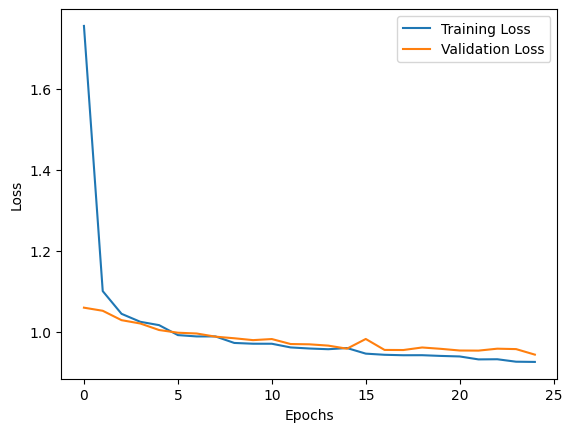

In [184]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predicciones

Obtener la exactitud del modelo

In [185]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Exactitud del modelo:", accuracy)

24/24 [==============================] - 0s 3ms/step
Exactitud del modelo: 0.5592105263157895


Comparaciones de las predicciones y valores reales (primeros 10)

In [186]:
print("Predicciones (primeros 10 elementos)  :", y_pred_labels[:10])
print("Valores reales (primeros 10 elementos):", y_test[:10].values)

Predicciones (primeros 10 elementos)  : [2 2 0 2 2 2 2 2 0 2]
Valores reales (primeros 10 elementos): [2 2 0 1 2 1 0 1 1 2]


Obtener los porcentajes de cada resultado

In [187]:
combined = pd.DataFrame({'Real': y_test, 'Prediccion': y_pred.argmax(axis=1)})
pd.crosstab(index=combined['Real'], columns=combined['Prediccion'])

Prediccion,0,1,2
Real,,,
0,127,4,81
1,66,13,130
2,49,5,285


Predicciones reales

In [188]:
combined = combined.merge(data[['HomeTeam', 'AwayTeam']], left_index=True, right_index=True)
combined

,Real,Prediccion,HomeTeam,AwayTeam
1003,2,2,11,16
594,2,2,30,14
461,0,0,1,2
3018,1,2,9,5
3091,2,2,11,0
...,...,...,...,...
1228,2,0,24,3
2480,2,2,22,19
2004,1,2,5,7
3022,2,2,3,22


#### Guardamos el modelo y la data

In [189]:
model.save('modelos/modelo1.h5')
data.to_csv('modelos/data1.csv', index=False)

c:\Users\rjmom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
